In [11]:
%pylab inline
import torch
from torch.autograd import Variable
from torch import nn
import loader
from qLearningNet import *
import time
from AIModels import *
from replayMemory import *
from threes import *
from g2048 import *
from easyGame import *
import os

LEARNING_RATES_TO_TRY = np.logspace(-3.0,1.0,4)
print LEARNING_RATES_TO_TRY

EPOCHS = 15000

MOVES = [0, 1, 2, 3]

FILENAME = "saved_parameters"
PLAYED_GAME = G2048
INPUT_SIZE = 16
ENTRY_LEN = 34
HIDDEN_SIZE = 256


DATA_HOLDER_PREFIX = "resultLoader2048best"

def testNet(filename=None, net=None):
    game = PLAYED_GAME(save_game=False)
    if filename is not None:
        ai = QLearningNetAI(game, filename=filename)
    elif net is not None:
        ai = QLearningNetAI(game, net=net)
    scores, move_count, highs = AIModel.test_ai(ai, 400, verbose=False)
    return move_count, np.mean(scores), np.mean(highs)

def plot_result(path, title):
    scores = np.loadtxt(path+'scores')
    q_values = np.loadtxt(path+'qvalues')
    loses = np.loadtxt(path+'loses')
    figure(figsize=(16,10))
    subplot(1,3,1)
    plot(range(100,len(scores)*100+1, 100), scores, marker='o')
    xlabel('Number of epochs')
    ylabel('Average score')
    subplot(1,3,2)
    plot(range(100,len(scores)*100+1, 100), np.log(loses), marker='o')
    xlabel('Number of epochs')
    ylabel('Loss')
    subplot(1,3,3)
    plot(range(100,len(scores)*100+1, 100), q_values, marker='o')
    xlabel('Number of epochs')
    ylabel('Q values')
    show()

test_q_set = loader.Loader.get_random_states(PLAYED_GAME(), 100, input_size=INPUT_SIZE)
print("bum")

Populating the interactive namespace from numpy and matplotlib
[  1.00000000e-03   2.15443469e-02   4.64158883e-01   1.00000000e+01]
bum


In [12]:
def train(model, data_loaders, optimizer, num_epochs=500, log_every=100, verbose=True, batch_size=100, \
          use_memory=True, gamma=0.8, filename_prefix=""):
    replays = ReplayMemory(10**5, entry_len=ENTRY_LEN)
        
    results = []
    losses = []
    q_values = []
    
    epoch = 0
    if verbose:
        print u'Training the model!'
        print u'Interrupt at any time to get current model'
    try:
        while epoch < num_epochs:
            epoch += 1
            
            new_data = data_loaders.get(model, batch_size)
            if use_memory:
                replays.add(new_data)
                x = replays.choose(batch_size)
            else:
                x = new_data
            
            future = x[:, (INPUT_SIZE+2):]
            future_scores = model.Q(future)
            for i, row in enumerate(future):
                game = PLAYED_GAME(save_game=False, data=row.tolist())
                for j, move in enumerate(MoveEnum):
                    if not game.canMove(move):
                        future_scores[i, j] = float('-inf')
                if not game.getPossibleMoves():
                    future_scores[i,:] = np.full((1,4), x[i, (INPUT_SIZE+1)])
                
            y = x[:, (INPUT_SIZE+1)] + gamma * np.max(future_scores, axis=1)
            xx = x[:, :INPUT_SIZE]

            optimizer.zero_grad()
            i = np.asarray(np.vstack((np.arange(0,batch_size),x[:,INPUT_SIZE])),int)
            
            i = torch.LongTensor(i)
            out = model.Q(xx, as_variable=True)[i[0],i[1]]
            loss = model.loss(out, y)
            loss.backward()
            optimizer.step()

            if epoch % log_every == 0 and verbose:
                print u"Minibatch {0: >6}  | loss {1: >15.12f} ".format(epoch, loss.data[0])
                result = testNet(net=model)
                print u"The average score was {}".format(result[1])
                results += [result[1]]
                losses += [loss.data.numpy()]
                q_val = model.Q(test_q_set)
                q_values += [np.mean(np.max(q_val, axis=1))]
                print u"The average Q function value was {}".format(q_values[-1])
                
            if epoch % (log_every * 20) == 0:
                result = testNet(net=model)
                filename = filename_prefix + FILENAME +'{}_{}'.format(epoch, int(result[1]))
                model.save_parameters(filename)
                

    except KeyboardInterrupt:
        pass
    result = testNet(net=model)
    filename = filename_prefix + FILENAME +'{}_{}'.format(epoch, int(result[1]))
    model.save_parameters(filename)
    return results, losses, q_values

In [ ]:
for lr in LEARNING_RATES_TO_TRY:
    path= DATA_HOLDER_PREFIX + "/results_lr_{:.5f}/".format(lr)
    print "Saving to",path
    try: 
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise
    q_learning_net = QLearningNet(input_size=INPUT_SIZE)
    for p in q_learning_net.network.parameters():
        p.requires_grad = True
    optimizer = torch.optim.Adam(q_learning_net.network.parameters(), lr=lr)
    data_loader = loader.Loader(game=PLAYED_GAME())
    scores, loses, q_values = train(q_learning_net, data_loader, optimizer, num_epochs=EPOCHS,filename_prefix=path)
    print "Learning for",lr,"done. (#learningdone)"
    np.savetxt(path+'scores', scores)
    np.savetxt(path+'loses', loses)
    np.savetxt(path+'qvalues', q_values)

Saving to resultLoader2048best/results_lr_0.00100/
Training the model!
Interrupt at any time to get current model
Minibatch    100  | loss  0.000347718305 
The average score was 1052.16
The average Q function value was 0.0293983835727
Minibatch    200  | loss  0.000802031951 
The average score was 1895.77
The average Q function value was 0.0253665074706
Minibatch    300  | loss  0.000583370624 
The average score was 1798.6
The average Q function value was 0.0277557540685
Minibatch    400  | loss  0.000661585305 
The average score was 1760.13
The average Q function value was 0.0299101024866
Minibatch    500  | loss  0.000432171306 
The average score was 1834.93
The average Q function value was 0.0281264856458
Minibatch    600  | loss  0.000527370023 
The average score was 1928.68
The average Q function value was 0.0275383777916
Minibatch    700  | loss  0.000611363212 
The average score was 1263.65
The average Q function value was 0.0270617119968
Minibatch    800  | loss  0.000489110360

Minibatch   6800  | loss  0.000533613958 
The average score was 1577.62
The average Q function value was 0.0262628886849
Minibatch   6900  | loss  0.000388783403 
The average score was 1340.8
The average Q function value was 0.0261495020241
Minibatch   7000  | loss  0.000456662296 
The average score was 1088.47
The average Q function value was 0.0253644343466
Minibatch   7100  | loss  0.000454568013 
The average score was 1456.77
The average Q function value was 0.0248664114624
Minibatch   7200  | loss  0.000445901416 
The average score was 1727.77
The average Q function value was 0.0241396762431
Minibatch   7300  | loss  0.000299082254 
The average score was 1233.8
The average Q function value was 0.0222321823239
Minibatch   7400  | loss  0.000308581948 
The average score was 1111.44
The average Q function value was 0.0251855906099
Minibatch   7500  | loss  0.000620445469 
The average score was 1655.18
The average Q function value was 0.026465350762
Minibatch   7600  | loss  0.0006607

Minibatch  13600  | loss  0.000386365980 
The average score was 1038.9
The average Q function value was 0.0254329256713
Minibatch  13700  | loss  0.000486211327 
The average score was 1517.54
The average Q function value was 0.0270377676934
Minibatch  13800  | loss  0.000359342725 
The average score was 1040.55
The average Q function value was 0.0246476437896
Minibatch  13900  | loss  0.000213251667 
The average score was 1226.48
The average Q function value was 0.0258886106312
Minibatch  14000  | loss  0.000489829283 
The average score was 1108.86
The average Q function value was 0.0250419192016
Minibatch  14100  | loss  0.000316701684 
The average score was 1097.26
The average Q function value was 0.0240758638829
Minibatch  14200  | loss  0.000287298608 
The average score was 1013.05
The average Q function value was 0.0265272911638
Minibatch  14300  | loss  0.000397992146 
The average score was 1003.96
The average Q function value was 0.0268595218658
Minibatch  14400  | loss  0.00023

Minibatch   5300  | loss  0.000603284920 
The average score was 2461.1
The average Q function value was 0.0219264123589
Minibatch   5400  | loss  0.000716405746 
The average score was 792.42
The average Q function value was 0.0269188657403
Minibatch   5500  | loss  0.000781119161 
The average score was 2338.44
The average Q function value was 0.0256246421486
Minibatch   5600  | loss  0.000613633718 
The average score was 2229.7
The average Q function value was 0.0341218523681
Minibatch   5700  | loss  0.000613733253 
The average score was 2005.06
The average Q function value was 0.0317396447062
Minibatch   5800  | loss  0.000499762362 
The average score was 2161.64
The average Q function value was 0.0229823254049
Minibatch   5900  | loss  0.000480922987 
The average score was 2408.69
The average Q function value was 0.0279415305704
Minibatch   6000  | loss  0.000603487948 
The average score was 1912.09
The average Q function value was 0.0237982552499
Minibatch   6100  | loss  0.0006582

Minibatch  12100  | loss  0.000561351073 
The average score was 807.51
The average Q function value was 0.0301495548338
Minibatch  12200  | loss  0.000652034418 
The average score was 794.45
The average Q function value was 0.0352004542947
Minibatch  12300  | loss  0.000810713158 
The average score was 854.32
The average Q function value was 0.0329377837479
Minibatch  12400  | loss  0.000763556338 
The average score was 2256.87
The average Q function value was 0.0304451305419
Minibatch  12500  | loss  0.000428396132 
The average score was 851.44
The average Q function value was 0.0357178375125
Minibatch  12600  | loss  0.000591839838 
The average score was 2465.2
The average Q function value was 0.024196524173
Minibatch  12700  | loss  0.000758541457 
The average score was 836.8
The average Q function value was 0.0200931858271
Minibatch  12800  | loss  0.000510525715 
The average score was 899.85
The average Q function value was 0.0313093587756
Minibatch  12900  | loss  0.000578307838 

Minibatch   3800  | loss  0.000727807404 
The average score was 2385.27
The average Q function value was 0.0325669944286
Minibatch   3900  | loss  0.000317459751 
The average score was 834.17
The average Q function value was 0.0220410842448
Minibatch   4000  | loss  0.000663278450 
The average score was 2460.02
The average Q function value was 0.0232384651899
Minibatch   4100  | loss  0.000957702112 
The average score was 2509.14
The average Q function value was 0.0260612480342
Minibatch   4200  | loss  0.000434077927 
The average score was 814.04
The average Q function value was 0.0272703599185
Minibatch   4300  | loss  0.000412204419 
The average score was 2356.18
The average Q function value was 0.0274931266904
Minibatch   4400  | loss  0.000728452113 
The average score was 2301.67
The average Q function value was 0.0331282019615
Minibatch   4500  | loss  0.000592700264 
The average score was 870.61
The average Q function value was 0.0304610542953
Minibatch   4600  | loss  0.0005038

Minibatch  10600  | loss  0.000606451067 
The average score was 2252.97
The average Q function value was 0.0395701862872
Minibatch  10700  | loss  0.000806110795 
The average score was 2358.62
The average Q function value was 0.024587308988
Minibatch  10800  | loss  0.000910411822 
The average score was 2505.76
The average Q function value was 0.0428006984293
Minibatch  10900  | loss  0.001159392181 
The average score was 2338.08
The average Q function value was 0.0357148423791
Minibatch  11000  | loss  0.001417506021 
The average score was 813.94
The average Q function value was 0.0437928065658
Minibatch  11100  | loss  0.000505182135 
The average score was 839.12
The average Q function value was 0.0238042473793
Minibatch  11200  | loss  0.000912731513 
The average score was 2411.33
The average Q function value was 0.0558937303722
Minibatch  11300  | loss  0.003815250471 
The average score was 2497.23
The average Q function value was 0.130239292979
Minibatch  11400  | loss  0.00112623

Minibatch   2300  | loss  0.001693160972 


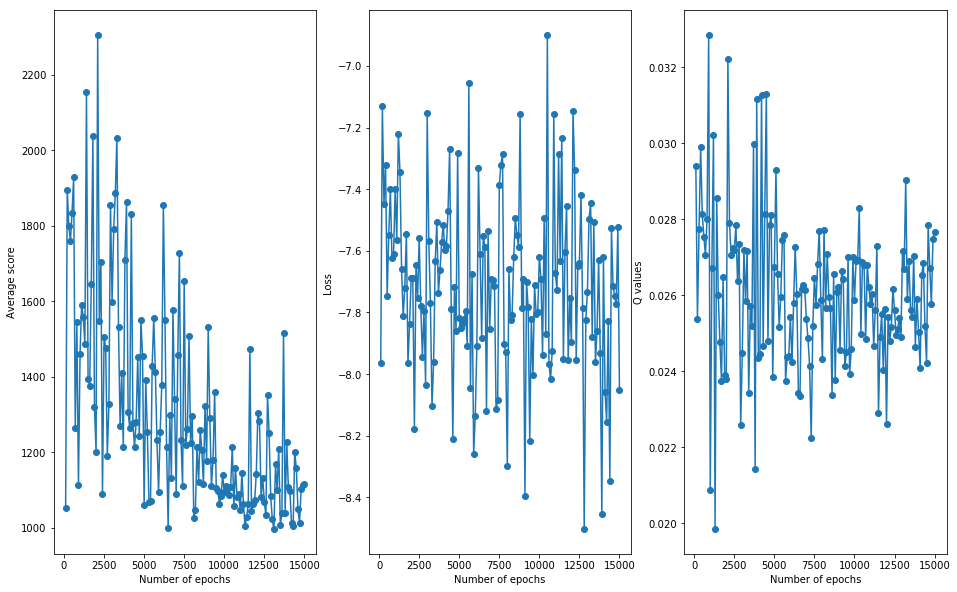

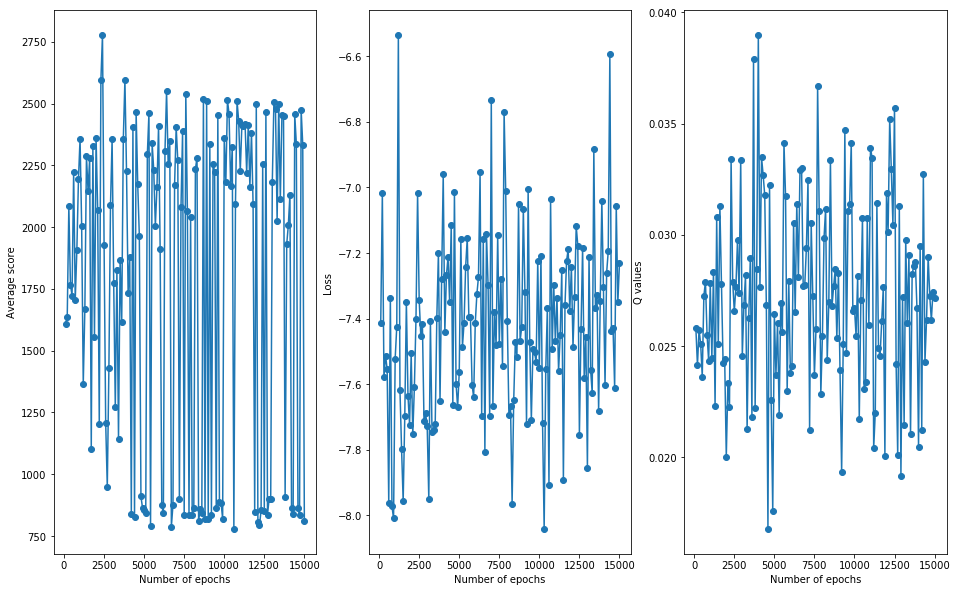

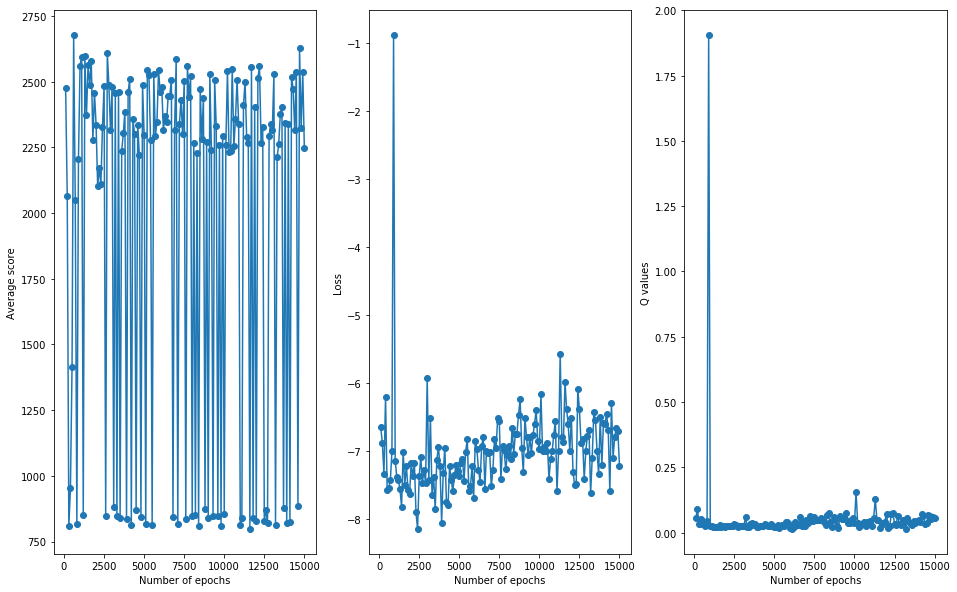

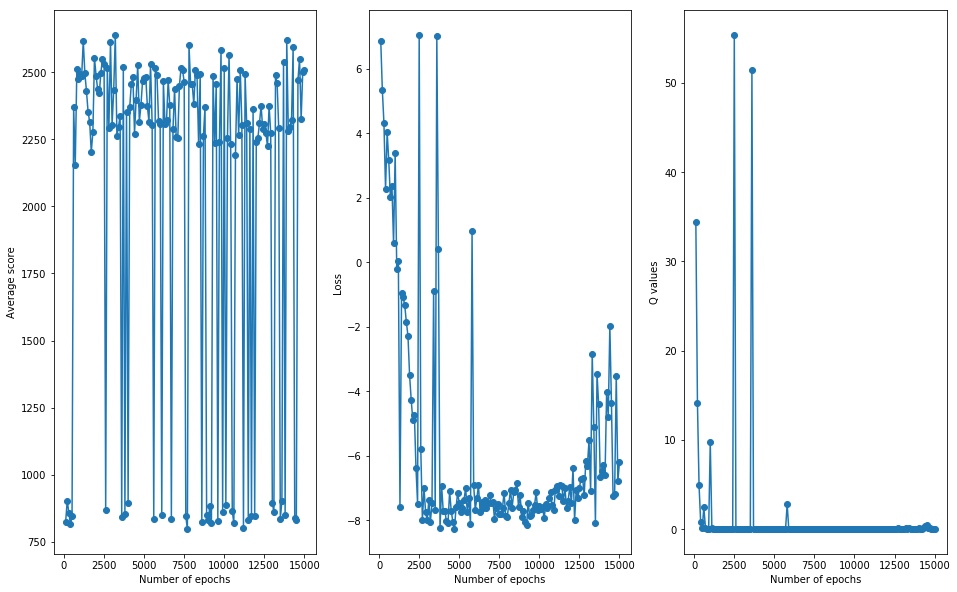

In [14]:
for lr in LEARNING_RATES_TO_TRY:
    path= DATA_HOLDER_PREFIX + "/results_lr_{:.5f}/".format(lr)
    plot_result(path, "MINMAX LR {}".format(lr))

In [31]:
game = PLAYED_GAME(save_game=False)
ai = RandomAI(game)
scores, move_count, highs = AIModel.test_ai(ai, 10, verbose=False)
print move_count
print np.mean(scores), np.mean(highs)

{'Down': 339, 'Right': 372, 'Up': 339, 'Left': 340}
1342.4 128.0


In [33]:
import os
for lr in LEARNING_RATES_TO_TRY:
    
    path= DATA_HOLDER_PREFIX + "/results_lr_{:.5f}/".format(lr)
    parameters_epochs = float("-inf")
    parameters_filename = ""
    for filename in os.listdir(path):
        if "saved_parameters" in filename:
            tmp_len = len("parameters")
            epochs = int(filename.split('_')[1][tmp_len:])
            if epochs > parameters_epochs:
                parameters_filename = filename
                parameters_epochs = epochs
    parameters_filename = path + parameters_filename
    print "With parameters from: " + parameters_filename
    game = PLAYED_GAME(save_game=False)
    net = QLearningNet(input_size=INPUT_SIZE)
    if filename is not None:
        print "Loading net parameters"
        net.load_parameters(parameters_filename)
    ai = QLearningNetAI(game, net=net)
    scores, move_count, highs = AIModel.test_ai(ai, 10, verbose=False)
    print move_count
    print np.mean(scores), np.mean(highs)

With parameters from: resultLoader2048best/results_lr_0.00100/saved_parameters15000_1081
Loading net parameters
{'Down': 296, 'Right': 304, 'Up': 237, 'Left': 151}
784.4 67.2
With parameters from: resultLoader2048best/results_lr_0.02154/saved_parameters15000_832
Loading net parameters
{'Down': 76, 'Right': 626, 'Up': 23, 'Left': 124}
622.8 60.8
With parameters from: resultLoader2048best/results_lr_0.46416/saved_parameters15000_2201
Loading net parameters
{'Down': 559, 'Right': 1922, 'Up': 0, 'Left': 132}
3155.6 240.0
With parameters from: resultLoader2048best/results_lr_10.00000/saved_parameters15000_2525
Loading net parameters
{'Down': 471, 'Right': 1388, 'Up': 89, 'Left': 1}
2156.8 185.6


In [36]:
import os
for lr in LEARNING_RATES_TO_TRY[0:1]:
    
    path= DATA_HOLDER_PREFIX + "/results_lr_{:.5f}/".format(lr)
    parameters_epochs = float("-inf")
    parameters_filename = ""
    for filename in os.listdir(path):
        if "saved_parameters" in filename:
            tmp_len = len("parameters")
            epochs = int(filename.split('_')[1][tmp_len:])
            if epochs > parameters_epochs:
                parameters_filename = filename
                parameters_epochs = epochs
    parameters_filename = path + parameters_filename
    print "With parameters from: " + parameters_filename
    game = PLAYED_GAME(save_game=False)
    net = QLearningNet(input_size=INPUT_SIZE)
    if filename is not None:
        print "Loading net parameters"
        net.load_parameters(parameters_filename)
    ai = QLearningNetAI(game, net=net)
    scores, move_count, highs = AIModel.test_ai(ai, 1, verbose=True)
    print move_count
    print np.mean(scores), np.mean(highs)

With parameters from: resultLoader2048best/results_lr_0.00100/saved_parameters15000_1081
Loading net parameters
   .    .    .    . 
   2    .    .    . 
   .    .    2    . 
   .    .    .    . 
[ 0.00024414  0.00048828  0.00073242  0.00097656  0.0625      0.00073242
  0.00097656  0.00146484  0.00073242  0.00097656  0.0625      0.00170898
  0.00024414  0.00048828  0.00146484  0.00195312]
Qvalues  ['0.104397438466549', '0.098128378391266', '0.046719923615456', '0.070625379681587']
Best move is MoveEnum.Left

   .    .    .    . 
   2    .    .    . 
   2    .    .    . 
   .    .    2    . 
[  9.53674316e-07   1.90734863e-06   2.86102295e-06   3.81469727e-06
   6.25000000e-02   2.86102295e-06   3.81469727e-06   5.72204590e-06
   6.25000000e-02   3.81469727e-06   2.44140625e-04   6.67572021e-06
   9.53674316e-07   1.90734863e-06   6.25000000e-02   7.62939453e-06]
Qvalues  ['0.062178485095501', '0.089655376970768', '0.011302458122373', '0.069588437676430']
Best move is MoveEnum.Up

   4 

Best move is MoveEnum.Right

   2    4    8    2 
   .    4   64   16 
   .    2    2   16 
   .    .    .    4 
[  6.25000000e-02   1.25000000e-01   1.87500000e-01   6.25000000e-02
   2.44140625e-04   1.25000000e-01   3.75000000e-01   2.50000000e-01
   3.72529030e-09   6.25000000e-02   6.25000000e-02   2.50000000e-01
   1.45519152e-11   1.32348898e-23   1.83670992e-40   1.25000000e-01]
Qvalues  ['0.012298082932830', '0.023798923939466', '0.027269277721643', '0.009580360725522']
Best move is MoveEnum.Right

   2    4    8    2 
   .    4   64   16 
   .    .    4   16 
   .    .    2    4 
[  6.25000000e-02   1.25000000e-01   1.87500000e-01   6.25000000e-02
   9.53674316e-07   1.25000000e-01   3.75000000e-01   2.50000000e-01
   1.45519152e-11   2.44140625e-04   1.25000000e-01   2.50000000e-01
   5.68434189e-14   5.16987883e-26   6.25000000e-02   1.25000000e-01]
Qvalues  ['0.012778365984559', '0.025911293923855', '0.027278836816549', '0.011102594435215']
Best move is MoveEnum.Up

   2  

[  1.87500000e-01   1.25000000e-01   3.12500000e-01   6.25000000e-02
   1.25000000e-01   6.25000000e-02   4.37500000e-01   1.25000000e-01
   9.53674316e-07   3.12500000e-01   1.87500000e-01   6.25000000e-02
   1.25000000e-01   6.25000000e-02   6.25000000e-02   1.25000000e-01]
Qvalues  ['0.013380995020270', '0.022235855460167', '0.020684624090791', '0.020745964720845']
Best move is MoveEnum.Up

   8    4   32    2 
   8    2  128    4 
   2   32    8    2 
   .    2    2    4 
[ 0.1875      0.125       0.3125      0.0625      0.1875      0.0625
  0.4375      0.125       0.0625      0.3125      0.1875      0.0625
  0.00048828  0.0625      0.0625      0.125     ]
Qvalues  ['0.002606429159641', '0.025355162099004', '0.024697154760361', '0.007291067391634']
Best move is MoveEnum.Up

  16    4   32    2 
   2    2  128    4 
   .   32    8    2 
   2    2    2    4 
[  2.50000000e-01   1.25000000e-01   3.12500000e-01   6.25000000e-02
   6.25000000e-02   6.25000000e-02   4.37500000e-01   1.25